In [1]:
!pip install keras==2.1.5 --no-deps

     |████████████████████████████████| 337kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive/google_colab_gpu/GSOC 2020/CERN-HSF

/content/drive/My Drive/google_colab_gpu/GSOC 2020/CERN-HSF


In [4]:
ls

ground_truth.csv       output.csv
Keras_CERN.ipynb       pytorch1.pt
Keras_inference.ipynb  Pytorch_CERN.ipynb
model1.h5              SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
model1.hdf5            SingleElectronPt50_IMGCROPS_n249k_RHv1_inference.hdf5
model1.json            SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
model2.h5              SinglePhotonPt50_IMGCROPS_n249k_RHv1_inference.hdf5


In [0]:
#import cv2
import numpy as np
import pandas as pd
#from google.colab.patches import cv2_imshow
import h5py

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import cv2
#from keras.datasets import mnist

from keras.utils import np_utils
from keras.models import Sequential,load_model, model_from_json
from keras.layers import Activation, BatchNormalization, Input, Conv1D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,LeakyReLU
from keras import optimizers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.callbacks import Callback
import keras


Using TensorFlow backend.


In [0]:
filename='SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
data1 = h5py.File(filename, 'r')
Y1=data1['y']
X1=data1['X']

In [0]:
filename='SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
data0 = h5py.File(filename, 'r')
Y0=data0['y']
X0=data0['X']

In [0]:
X_final=np.concatenate((X0[:],X1[:]),axis=0)
Y_final=np.concatenate((Y0[:],Y1[:]),axis=0)

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
X_train,X_valid, Y_train, Y_valid = train_test_split(X_final,Y_final,test_size = 0.2, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_valid.shape,Y_valid.shape)

In [12]:
X_train0=(X_train[:,:,:,0].reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1)))
X_valid0=(X_valid[:,:,:,0].reshape((X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)))
X_train1=(X_train[:,:,:,1].reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1)))
X_valid1=(X_valid[:,:,:,1].reshape((X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)))
X_train.shape,X_valid.shape,X_train0.shape,X_valid0.shape,X_train1.shape,X_valid1.shape

((398400, 32, 32, 2),
 (99600, 32, 32, 2),
 (398400, 32, 32, 1),
 (99600, 32, 32, 1),
 (398400, 32, 32, 1),
 (99600, 32, 32, 1))

In [0]:
window_height=32
window_width=32

In [0]:
inputs_1 = Input(shape=(window_height,window_width,1),name='input_image')
x=Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(window_height,window_width,1))(inputs_1)
x=MaxPool2D(pool_size=(2, 2),strides=(2,2))(x)
x=Conv2D(32, (3, 3), activation='relu',padding='same')(x)
#x1=BatchNormalization(momentum=0.5)(x1)
x=MaxPool2D(pool_size=(2, 2),strides=(2,2))(x)
x=Conv2D(64, (3, 3), activation='relu',padding='same')(x)
#x1=BatchNormalization(momentum=0.5)(x1)
x=Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x=MaxPool2D(pool_size=(2, 2),strides=(2,2))(x)
x=Conv2D(128, (3, 3), activation='relu',padding='same')(x)
#x=Conv2D(256, (3, 3), activation='relu',padding='same')(x)
x=MaxPool2D(pool_size=(2, 2),strides=(2,2))(x)
#x=Conv2D(256, (3, 3), activation='relu',padding='same')(x)
#x=Conv2D(256, (3, 3), activation='relu',padding='same')(x)
#x=MaxPool2D(pool_size=(2, 2),strides=(2,2))(x)
x=Flatten()(x)
x1=Dense(512,activation='relu')(x)
x1=Dense(128,activation='relu')(x)
#x1=BatchNormalization()(x1)
#x1=Dropout(0.5)(x1)
#x1=Dense(64,activation='relu')(x1)
#x1=Dense(128,activation='relu')(x1)
x1=Dense(1,activation='sigmoid')(x1)

model1 = Model(inputs=[inputs_1], outputs=x1)
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          36928     
__________

In [0]:
adam=optimizers.adam(lr=0.001)
model1.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = [f1_m,precision_m, recall_m, 'accuracy','mae'])

In [0]:
model1.fit(X_train0,Y_train,batch_size=1024, epochs=15, validation_data=(X_valid0,Y_valid))




Train on 398400 samples, validate on 99600 samples
Epoch 1/15





398400/398400 [==============================] - 22s 56us/step - loss: 0.6199 - f1_m: 0.6679 - precision_m: 0.6493 - recall_m: 0.7040 - acc: 0.6582 - mean_absolute_error: 0.4321 - val_loss: 0.5841 - val_f1_m: 0.7246 - val_precision_m: 0.6753 - val_recall_m: 0.7821 - val_acc: 0.7031 - val_mean_absolute_error: 0.4015
Epoch 2/15
398400/398400 [==============================] - 9s 23us/step - loss: 0.5797 - f1_m: 0.7144 - precision_m: 0.6948 - recall_m: 0.7402 - acc: 0.7057 - mean_absolute_error: 0.3948 - val_loss: 0.5749 - val_f1_m: 0.7194 - val_precision_m: 0.6956 - val_recall_m: 0.7452 - val_acc: 0.7095 - val_mean_absolute_error: 0.3858
Epoch 3/15
398400/398400 [==============================] - 9s 23us/step - loss: 0.5706 - f1_m: 0.7220 - precision_m: 0.7021 - recall_m: 0.7468 - acc: 0.7135 - mean_absolute_error: 0.3868 - val_loss: 0.5778 - val_f1_m: 0.6955 - val_precision_m: 0.7260 - val_recall_m: 0.6678 - val_acc: 

In [0]:
# serialize model to JSON
model_json = model1.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("model1.hdf5")
print("Saved model to disk")

Saved model to disk


In [14]:
# load json and create model
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model1 = model_from_json(loaded_model_json)
# load weights into new model
model1.load_weights("model1.hdf5")
print("Loaded model from disk")










Loaded model from disk


In [15]:
adam=optimizers.adam(lr=0.001)
model1.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = [f1_m,precision_m, recall_m, 'accuracy','mae'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model1.evaluate(X_valid0,Y_valid,verbose=1)

99600/99600 [==============================] - 14s 138us/step


[0.5525859504435436,
 0.732163390385578,
 0.7090966943277413,
 0.7698570608518209,
 0.7266566265060241,
 0.35171728847496003]

In [0]:
model1.metrics_names

['loss', 'f1_m', 'precision_m', 'recall_m', 'acc', 'mean_absolute_error']

In [0]:
from sklearn.metrics import roc_curve
y_pred = model1.predict(X_valid0).ravel()
fpr, tpr, thresholds = roc_curve(Y_valid, y_pred)

In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)

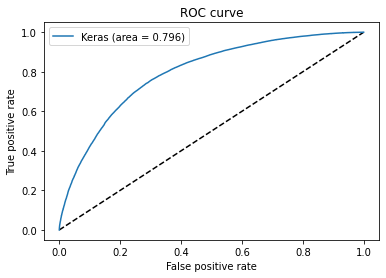

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
